# Visualisation 

In [1]:
import os
import torch
import time
import os.path as osp
import pandas as pd
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
import multiprocessing


from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.data import Dataset, Data
from tqdm import tqdm
from multiprocessing import Pool

In [2]:
from data.visualize_sample import draw_graph

In [3]:
class OCTADataset(Dataset):
    def __init__(self, root='/media/data/anna_alex/OCTA-500_6mm/train_data', transform=None, pre_transform=None, pre_filter=None):
        img_folder = osp.join(root, 'raw')
        graphs_folder = osp.join(root, 'graphs')

        node_files = []
        edge_files = []

        for file_ in os.listdir(img_folder):
            file_ = file_[:-8]
            node_files.append(osp.join(graphs_folder, file_ + 'seg_nodes.csv'))
            edge_files.append(osp.join(graphs_folder, file_ + 'seg_edges.csv'))

        data_dicts = [
            {"nodes": node_file, "edges": edge_file} for
            node_file, edge_file in zip(node_files, edge_files)
        ]
        self.data = data_dicts
        
        super().__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return [d['edges'] for d in self.data]

    @property
    def processed_file_names(self):
        return [f'data_{idx}.pt' for idx, _ in enumerate(self.data)]

    def download(self):
        pass

    def process(self):
        for idx in tqdm(range(len(self.raw_paths))):

            data = self.data[idx]
            nodes = pd.read_csv(data['nodes'], sep=";", index_col="id")
            edges = pd.read_csv(data['edges'], sep=";", index_col="id")
            
            nodes_pos = torch.tensor(nodes.to_numpy()[:, :2].astype(np.float32) / 128.)
            edges = torch.tensor(edges.to_numpy()[:, :2].astype(int)).t()

            nodes_ones = torch.ones(nodes_pos.size(0)).view(-1, 1)

            data = Data(
                x=nodes_ones,
                edge_index=edges,
                pos=nodes_pos,
            )

            torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [4]:
def plot_ged_res(results):
    rows = len(results)
    cols = 2
    
    fig = plt.figure()
    fig.set_size_inches(8, 4 * rows)

    subfigs = fig.subfigures(rows, 1)

    for i, res in enumerate(results):
        g1 = res['pair'][0]
        g2 = res['pair'][1]
        distance = res['ged']
        
        (ax1, ax2) = subfigs[i].subplots(1, 2)

        graph1 = to_networkx(g1).to_undirected()
        draw_graph(g1.pos, g1.edge_index.t(), ax1)

        graph2 = to_networkx(g2).to_undirected()
        draw_graph(g2.pos, g2.edge_index.t(), ax2)
        
        subfigs[i].suptitle(f"GED: {distance}", fontsize=12)

In [5]:
def compute_ged(args):
    data_pair, timeout = args
    graph1 = to_networkx(data_pair[0]).to_undirected()
    graph2 = to_networkx(data_pair[1]).to_undirected()
    distance = nx.graph_edit_distance(graph1, graph2, timeout=timeout)
    return {'pair': data_pair, 'ged': distance}

def ged(graph_pairs, num_processes=multiprocessing.cpu_count(), timeout=30):
    args = [(graph_pair, timeout) for graph_pair in graph_pairs]
    with Pool(processes=num_processes) as pool:
        results = pool.map(compute_ged, args, chunksize=1)
    return results

In [6]:
dataset = OCTADataset()

In [7]:
data_loader = DataLoader(dataset, batch_size=2, shuffle=True)

## Random pairs

In [8]:
# num_pairs = 200
# graph_pairs = [next(iter(data_loader)) for _ in range(num_pairs)]

# timeout=30
# ged_res = sorted(ged(graph_pairs, timeout=timeout), key=lambda x: x['ged'])

# torch.save(ged_res, f'ged_real_t{timeout}_n{num_pairs}.pth')
# plot_ged_res(ged_res)

In [9]:
# num_pairs = 50
# graph_pairs = [next(iter(data_loader)) for _ in range(num_pairs)]
# for c_s in [1, 2, 4, 8]:
#     ged(graph_pairs, chunksize=c_s, timeout=20)
    
    
# Execution time with 1 chunksize: 100.33462166786194 seconds
# Execution time with 2 chunksize: 103.84141159057617 seconds
# Execution time with 4 chunksize: 120.53054809570312 seconds

In [10]:
num_pairs = 200
graph_pairs = [next(iter(data_loader)) for _ in range(num_pairs)]

timeout=30
ged_res = sorted(ged(graph_pairs, timeout=timeout), key=lambda x: x['ged'])

torch.save(ged_res, f'ged_real_t{timeout}_n{num_pairs}.pth')

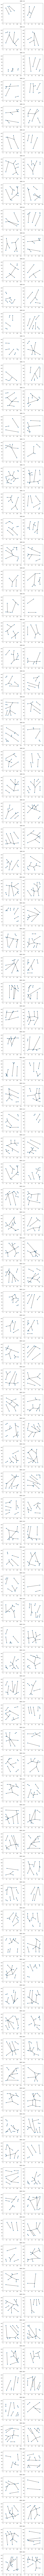

In [11]:
plot_ged_res(ged_res[:100])

## One random with 100 others

In [16]:
query = dataset[273]
graph_pairs = [(query, graph) for graph in dataset[:200]]

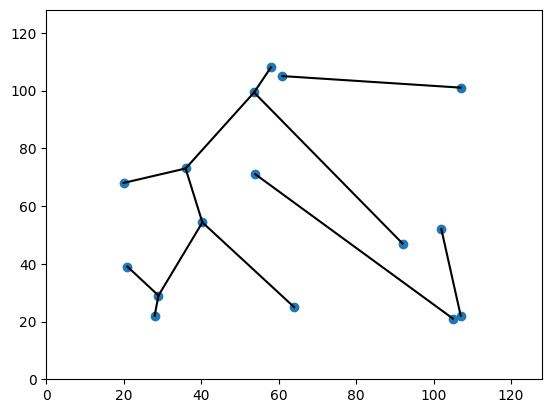

In [22]:
fig, ax = plt.subplots(1, 1)
draw_graph(query.pos, query.edge_index.t(), ax)

In [ ]:
timeout=30
ged_res = sorted(ged(graph_pairs, timeout=timeout), key=lambda x: x['ged'])

torch.save(ged_res, f'one_to_many_ged_real_t{timeout}_n{num_pairs}.pth')

In [ ]:
timeout=60
ged_res = sorted(ged(graph_pairs, timeout=timeout), key=lambda x: x['ged'])

torch.save(ged_res, f'one_to_many_ged_real_t{timeout}_n{num_pairs}.pth')